In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests 

from sodapy import Socrata

from fiona.crs import from_epsg

### Geometries

In [2]:
cook_bgroup = gpd.read_postgis("select state, county, tract, bgroup, geomsimp as geom "
                               "from census_bg_2010 "
                               "where state = 17 and county = 31 and tract < 980000 and pop > 1;", 
                               con = cen_con, geom_col = "geom", index_col = ["state", "county", "tract", "bgroup"],
                               crs = from_epsg(2163)).to_crs(epsg = 3528)

cook_tracts = gpd.read_postgis("select state, county, tract, geom "
                               "from census_tracts_2010 "
                               "where state = 17 and county = 31 and tract < 980000 and pop > 1;", 
                               con = cen_con, geom_col = "geom", index_col = ["state", "county", "tract"],
                               crs = from_epsg(2163)).to_crs(epsg = 3528)

### FCC 477

In [3]:
if False:

    client = Socrata("opendata.fcc.gov", None)
    results = client.get("sgz3-kiqt", limit=800000, where="starts_with(blockcode, '17031')")
    cook_fcc = pd.DataFrame.from_records(results)
    
    cook_fcc.to_csv("data/chicago_fcc.csv")
    
else: 
    
    cook_fcc = pd.read_csv("data/chicago_fcc.csv", 
                           usecols = ["blockcode", "frn", "provider_id", "dbaname", "consumer",
                                      "maxcirdown", "maxcirup", "maxaddown", "maxadup"])

In [4]:
cook_fcc.rename(columns = {"blockcode" : "geoid"}, inplace = True)

cook_fcc["state"]  = (cook_fcc.geoid // 1e13)
cook_fcc["county"] = (cook_fcc.geoid // 1e10 % 1e3).astype(int)
cook_fcc["tract"]  = (cook_fcc.geoid // 1e4  % 1e6).astype(int)
cook_fcc["bgroup"] = (cook_fcc.geoid // 1e3  % 1e1).astype(int)
cook_fcc["block"]  = (cook_fcc.geoid  % 1e3).astype(int)

cook_fcc = cook_fcc[["frn", "provider_id", "dbaname", "consumer", 
                     "maxcirdown", "maxcirup", "maxaddown", "maxadup",
                     "state", "county", "tract", "bgroup", "block", "geoid"]]

cook_fcc_all = cook_fcc.copy()
cook_fcc.query("consumer == 1", inplace = True)

In [5]:
geog = ["state", "county", "tract"]

nisp_bus = cook_fcc_all.groupby(geog).provider_id.nunique().rename("nisp_all")
nisp = cook_fcc.groupby(geog).provider_id.nunique().rename("nisp")

num_broadband_C_L = lambda g: g[(g.maxcirdown >= 25) & (g.maxcirup >= 3)].provider_id.nunique()
num_broadband_C = cook_fcc.groupby(geog).apply(num_broadband_C_L).rename("n25c")

num_broadband_C100_L = lambda g: g[(g.maxcirdown >= 100) & (g.maxcirup >= 10)].provider_id.nunique()
num_broadband_C100 = cook_fcc.groupby(geog).apply(num_broadband_C100_L).rename("n100c")

num_broadband_A_L = lambda g: g[(g.maxaddown >= 25) & (g.maxadup >= 3)].provider_id.nunique()
num_broadband_A = cook_fcc.groupby(geog).apply(num_broadband_A_L).rename("n25a")

num_broadband_A100_L = lambda g: g[(g.maxaddown >= 100) & (g.maxadup >= 10)].provider_id.nunique()
num_broadband_A100 = cook_fcc.groupby(geog).apply(num_broadband_A_L).rename("n100a")

cmax_down = cook_fcc.groupby(geog).maxcirdown.max().rename("cmax_down")
cmax_down_cat = pd.cut(cmax_down, [0, 0.5, 1, 2, 5, 25, 100, 500, 1000], include_lowest = True).rename("cmax_cat")

amax_down = cook_fcc.groupby(geog).maxaddown.max().rename("amax_down")
amax_down_cat = pd.cut(amax_down, [0, 0.5, 1, 2, 5, 25, 100, 500, 1000], include_lowest = True).rename("amax_cat")

More broadly, we have some "holes" in coverage that the "official" map doesn't report, like this one (170316713001021).  This seems to come from using maxcirdown, which is not reliably used.

In [6]:
cook_fcc.query("geoid == 170316713001021")

,frn,provider_id,dbaname,consumer,maxcirdown,maxcirup,maxaddown,maxadup,state,county,tract,bgroup,block,geoid
130768,12369286,53153,HughesNet,1,0.0,0.0,25.0,3.000,17,31,671300,1,21,170316713001021
229216,18756155,53601,Skycasters,1,0.0,0.0,2.0,1.300,17,31,671300,1,21,170316713001021
383461,2860856,49695,AT&T Illinois,1,0.0,0.0,6.0,0.512,17,31,671300,1,21,170316713001021
465911,2860856,49695,AT&T Illinois,1,0.0,0.0,18.0,0.768,17,31,671300,1,21,170316713001021
531043,2860856,49695,AT&T Illinois,1,0.0,0.0,100.0,20.000,17,31,671300,1,21,170316713001021
630419,4963088,50820,Viasat Inc,1,0.0,0.0,35.0,3.000,17,31,671300,1,21,170316713001021
736851,3768165,53458,Comcast,1,0.0,0.0,987.0,35.000,17,31,671300,1,21,170316713001021


For example, Comcast never reports cirdown.

In [7]:
cook_fcc.query("(dbaname == 'Comcast')").shape[0], \
cook_fcc.query("(dbaname == 'Comcast') & (maxcirdown > 0)").shape[0]

(79361, 0)

It's also not clear if the "consumer" variable is reliable, but it has a _huge_ impact on coverage.

### Get and Process Some ACS Observables...

In [8]:
var_dict = {"DP02_0152PE" : "Broadband", 
            "DP05_0038PE" : "Black", "DP05_0071PE" : "Hispanic", 
            "DP03_0062E"  : "MHI", "DP02_0064PE" : "BA"}

api = "https://api.census.gov/data/2018/acs/acs5/profile"
var = "?get=" + ",".join(var_dict)
geo = "&for=tract:*&in=state:17&in=county:031"

resp = requests.get(api + var + geo).json()

acs = pd.DataFrame(columns = resp[0], data = resp[1:])

for v in var_dict: acs[v] = acs[v].astype(float)
for v in ["state", "county", "tract"]: acs[v] = acs[v].astype(int)

acs.rename(columns = var_dict, inplace = True)
for v in ["Black", "Hispanic", "BA", "Broadband"]: acs[v] /= 100.

acs["logMHI"] = np.log(acs["MHI"])

acs.set_index(geog, inplace = True)

/home/jsaxon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in log


### Assemble and Plot

In [9]:
cook_broadband_gdf = cook_tracts.join([acs, nisp, nisp_bus, num_broadband_C, 
                                   num_broadband_C100, num_broadband_A, num_broadband_A100,
                                   cmax_down, cmax_down_cat, amax_down, amax_down_cat])

cook_broadband_df = pd.DataFrame(cook_broadband_gdf)

In [10]:
style_kws = {"cmap" : "Blues", "linewidth" : 0.05, "edgecolor" : "k", "legend" : True}

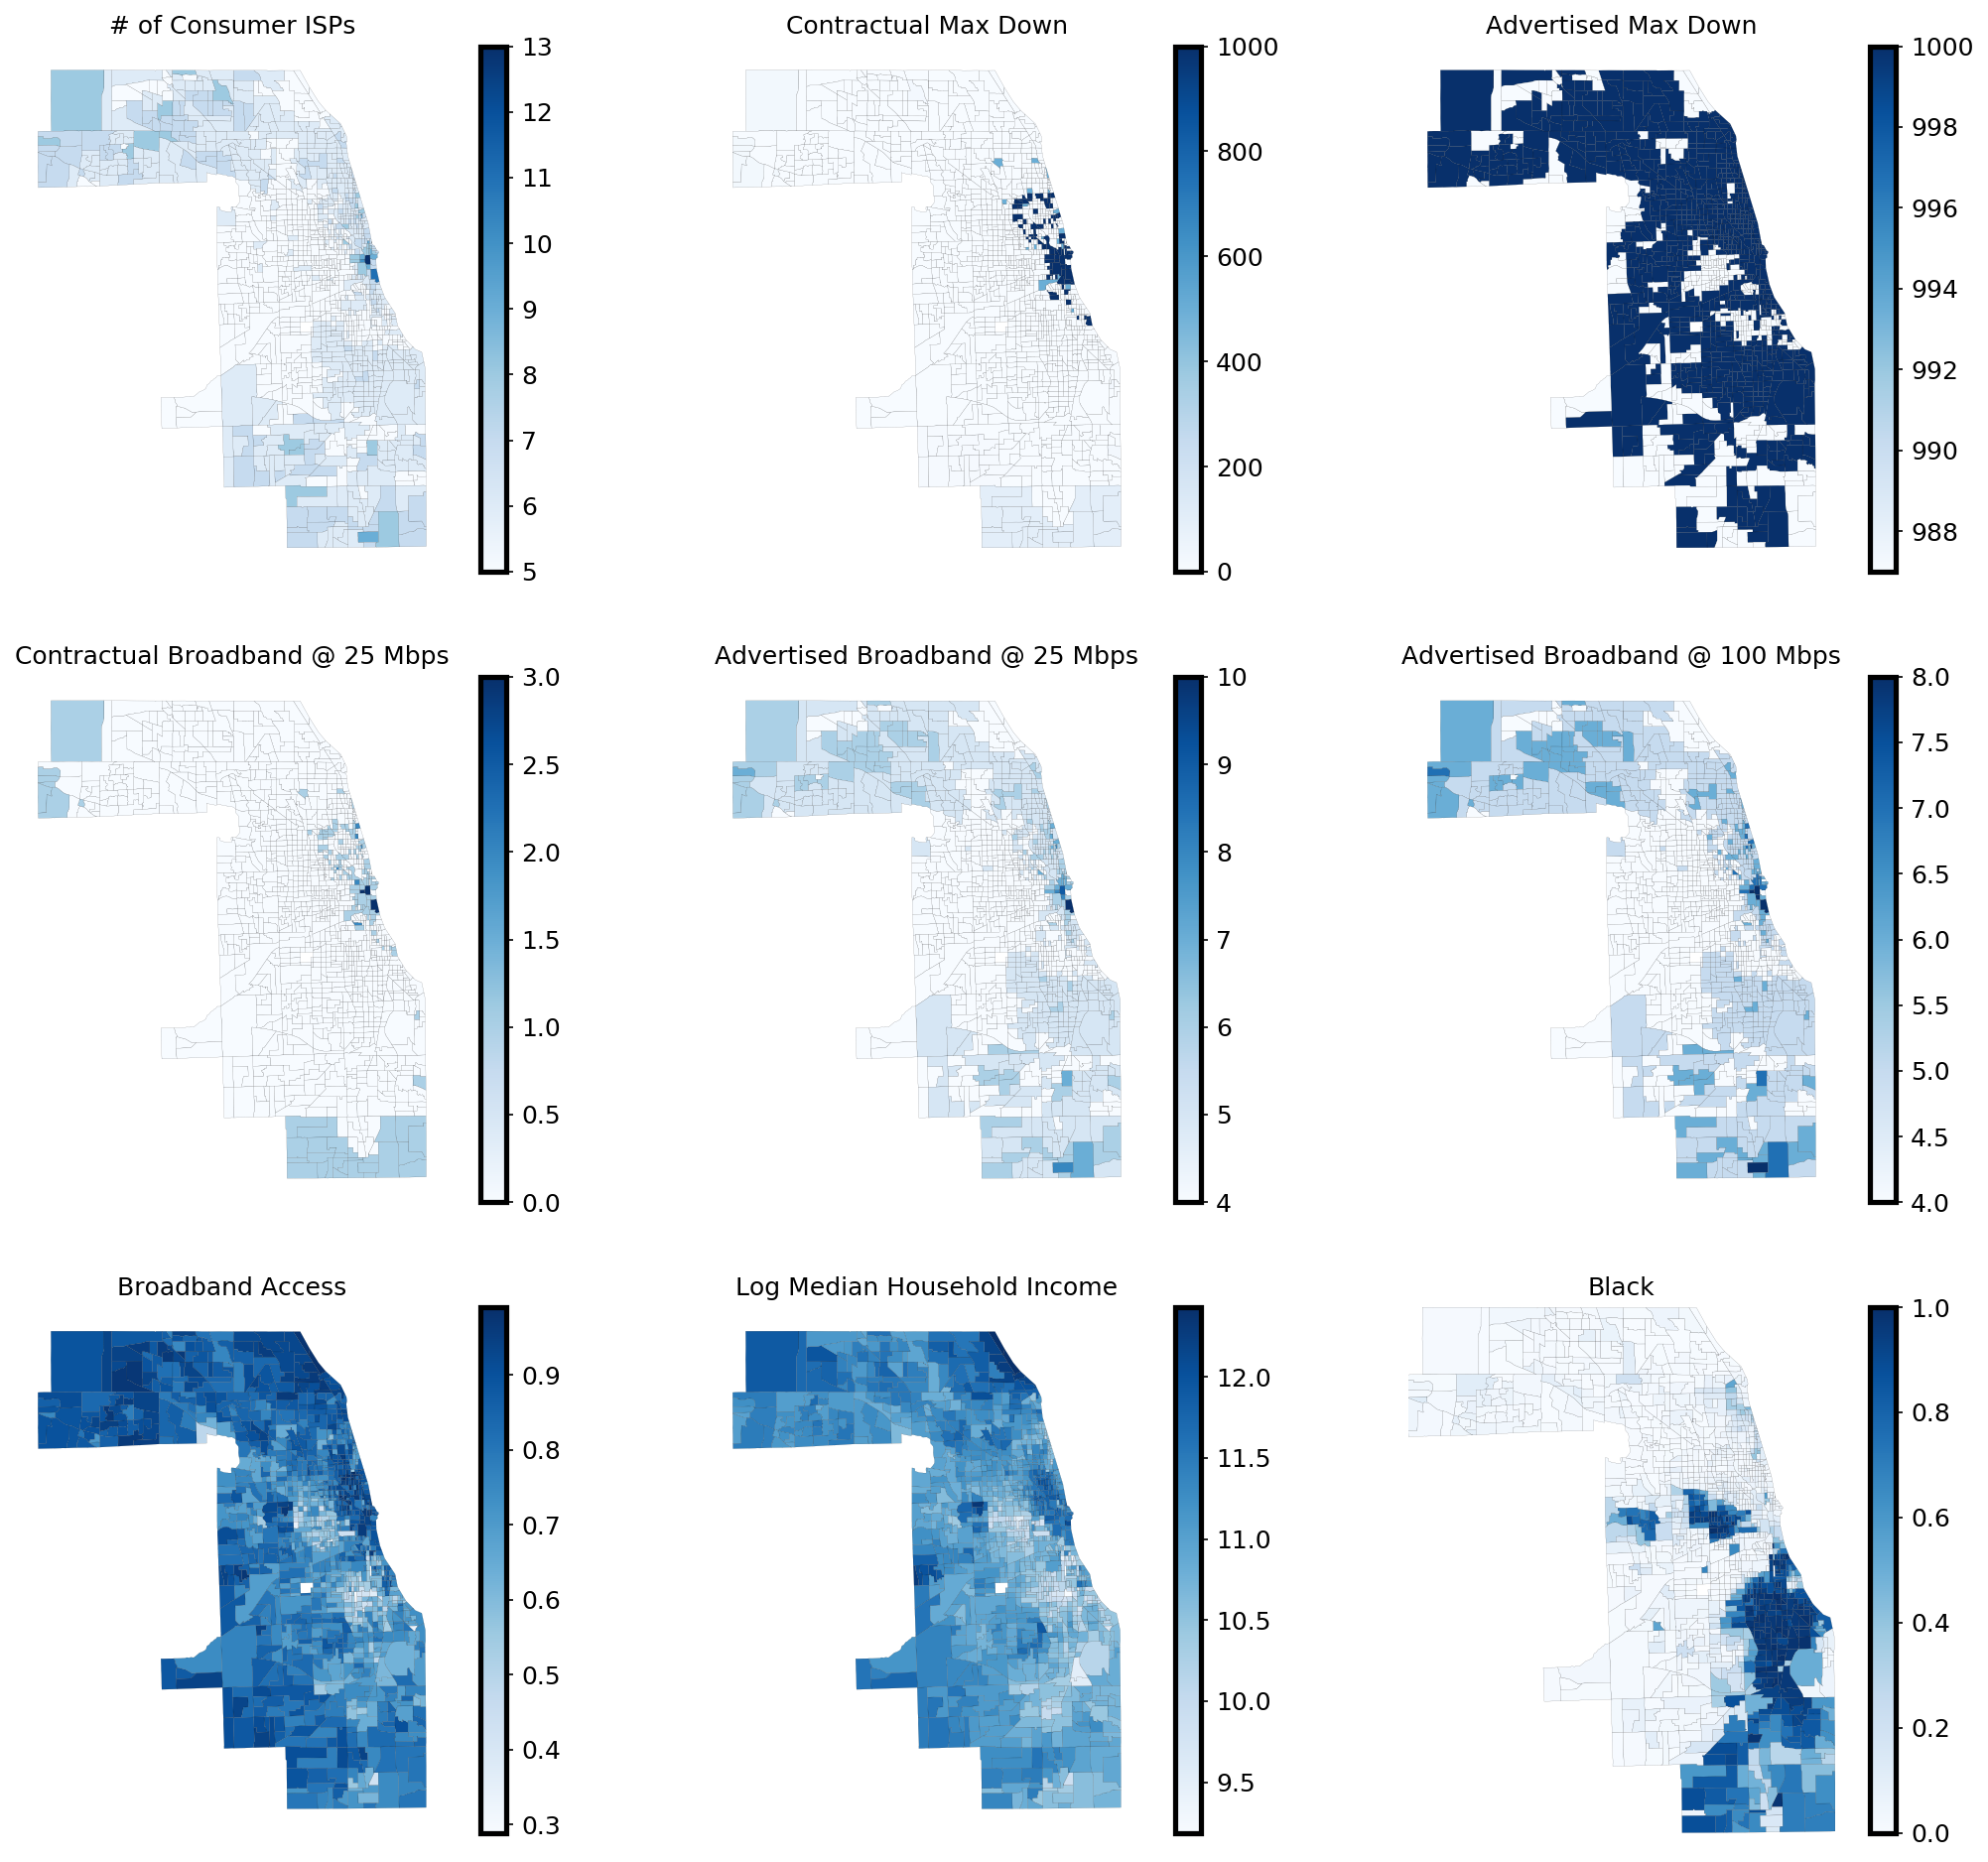

In [11]:
fig, ax = plt.subplots(3, 3, figsize = (14, 12))

for axi in ax.flatten(): map_format(axi)

ax[0][0].set_title("# of Consumer ISPs")
cook_broadband_gdf.plot(column = "nisp", **style_kws, ax = ax[0][0])

ax[0][1].set_title("Contractual Max Down")
cook_broadband_gdf.plot(column = "cmax_down", **style_kws, ax = ax[0][1])

ax[0][2].set_title("Advertised Max Down")
cook_broadband_gdf.plot(column = "amax_down", **style_kws, ax = ax[0][2])

ax[1][0].set_title("Contractual Broadband @ 25 Mbps")
cook_broadband_gdf.plot(column = "n25c", **style_kws, ax = ax[1][0])

ax[1][1].set_title("Advertised Broadband @ 25 Mbps")
cook_broadband_gdf.plot(column = "n25a", **style_kws, ax = ax[1][1])

ax[1][2].set_title("Advertised Broadband @ 100 Mbps")
cook_broadband_gdf.plot(column = "n100a", vmax = 8, **style_kws, ax = ax[1][2])

ax[2][0].set_title("Broadband Access")
cook_broadband_gdf.plot(column = "Broadband", **style_kws, ax = ax[2][0])

ax[2][1].set_title("Log Median Household Income")
cook_broadband_gdf.plot(column = "logMHI", **style_kws, ax = ax[2][1])

ax[2][2].set_title("Black")
cook_broadband_gdf.plot(column = "Black", **style_kws, ax = ax[2][2])

plt.subplots_adjust(hspace = 0.20)

fig.savefig("fcc_maps.pdf")

Text(0.6,1.08,'Broadband Access on the South Side')

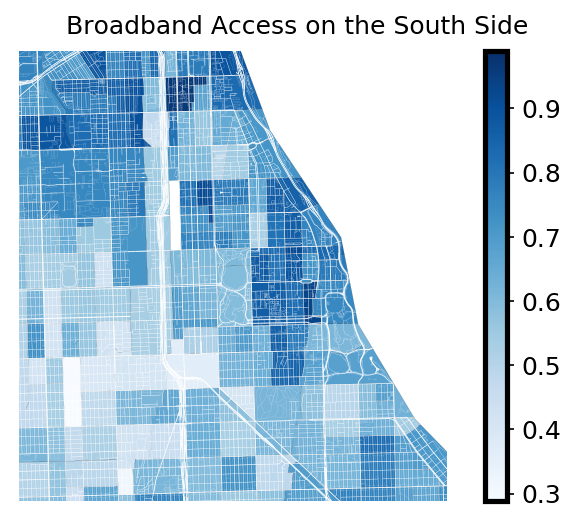

In [12]:
ax = cook_broadband_gdf.plot(column = "Broadband", **style_kws, figsize = (5, 3))

streets = gpd.read_file("streets_lw.geojson")
streets.plot(color = "w", lw = streets.highway_thickness / 10, ax = ax)

map_format(ax)
ax.set_xlim(355000, 365000)
ax.set_ylim(564500, 575000)

ax.figure.suptitle("Broadband Access on the South Side", x = 0.6, y = 1.08)

### Now let's investigate a bit...

In [13]:
cook_broadband_df[["Broadband", "BA", "MHI", "logMHI", "Black", "Hispanic",
                   "nisp", "nisp_all", "n25c", "n25a", "n100a", "cmax_down", "amax_down"]]\
 .corr().abs().round(3).style.background_gradient(cmap='viridis')

,Broadband,BA,MHI,logMHI,Black,Hispanic,nisp,nisp_all,n25c,n25a,n100a,cmax_down,amax_down
Broadband,1,0.719,0.751,0.833,0.589,0.175,0.271,0.264,0.152,0.251,0.251,0.162,0.241
BA,0.719,1,0.725,0.731,0.475,0.374,0.341,0.283,0.245,0.34,0.34,0.319,0.322
MHI,0.751,0.725,1,0.941,0.533,0.231,0.207,0.261,0.105,0.185,0.185,0.143,0.24
logMHI,0.833,0.731,0.941,1,0.64,0.138,0.233,0.295,0.126,0.209,0.209,0.156,0.289
Black,0.589,0.475,0.533,0.64,1,0.406,0.07,0.268,0.072,0.05,0.05,0.13,0.195
Hispanic,0.175,0.374,0.231,0.138,0.406,1,0.251,0.083,0.057,0.242,0.242,0.051,0.028
nisp,0.271,0.341,0.207,0.233,0.07,0.251,1,0.544,0.58,0.948,0.948,0.469,0.322
nisp_all,0.264,0.283,0.261,0.295,0.268,0.083,0.544,1,0.34,0.461,0.461,0.316,0.155
n25c,0.152,0.245,0.105,0.126,0.072,0.057,0.58,0.34,1,0.587,0.587,0.843,0.09
n25a,0.251,0.34,0.185,0.209,0.05,0.242,0.948,0.461,0.587,1,1,0.486,0.365


In [14]:
cook_broadband_df.corr().Broadband.abs().sort_values(ascending = False)[1:].round(3)

logMHI       0.833
MHI          0.751
BA           0.719
Black        0.589
nisp         0.271
nisp_all     0.264
n100a        0.251
n25a         0.251
amax_down    0.241
Hispanic     0.175
cmax_down    0.162
n25c         0.152
n100c        0.144
Name: Broadband, dtype: float64

/home/jsaxon/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


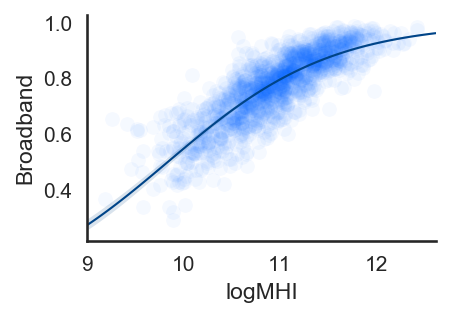

In [15]:
import seaborn as sns
sns.set_style("white")

fig, ax = plt.subplots(figsize = (3, 2))

ax.set_xlabel("Log Median Household Income")
ax.set_ylabel("Has Broadband")

sns.regplot(data = cook_broadband_df, x = "logMHI", y = "Broadband", 
            scatter_kws = {"alpha" : 0.04, "s" : 50, "color" : "#0066FF"}, 
            line_kws    = {"lw" : 1, "color" : "#004488"}, 
            logistic = True, ax = ax)

In [16]:
import statsmodels.formula.api as smf

from statsmodels.discrete.discrete_model import Logit as logit, Probit as probit

In [17]:
cook_broadband_df["C"] = 1  ## Add a constant

In [18]:
exog = ["logMHI", "nisp", "n25a", "BA", "Black", "Hispanic", "C"]
logit(cook_broadband_df.Broadband, cook_broadband_df[exog]).fit().summary()    

Optimization terminated successfully.
         Current function value: 0.397519
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Broadband   No. Observations:                 1314
Model:                          Logit   Df Residuals:                     1307
Method:                           MLE   Df Model:                            6
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                  -3.899
Time:                        17:54:13   Log-Likelihood:                -522.34
converged:                       True   LL-Null:                       -106.63
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logMHI         0.8085      0.222      3.646      0.000       0.374       1.243
nisp           0.0416      0.298      0.140      0.889      -0.543       0.627
n25a          -0.0090      0.321     -0.028      0.978      -0.639       0.621
BA             1.3575      1.022      1.328      0.184      -0.645       3.360
Black         -0.2624      0.347     -0.756      0.450      -0.943       0.418
Hispanic      -0.2881      0.407     -0.708      0.479      -1.086       0.510
C             -7.8820      2.448     -3.219      0.001     -12.681      -3.083
==============================================================================
"""

In [19]:
for name, exog in {"MHI"  : ["logMHI", "C"],
                   "ACS"  : ["logMHI", "BA", "Black", "Hispanic", "C"],
                   "Race" : ["Black", "Hispanic", "C"],
                   "FCC"  : ["nisp", "n25a", "C"],
                   "All"  : ["nisp", "n25a", "logMHI", "BA", "Black", "Hispanic", "C"],
                  }.items():

    lfit = logit(cook_broadband_df.Broadband, cook_broadband_df[exog]).fit()
    cook_broadband_df["pred" + name] = lfit.predict(cook_broadband_df[exog])
    
print("\n ** CORRELATIONS FOR PREDICTED LOGIT MODELS **")
cook_broadband_df.corr().Broadband.abs().sort_values(ascending = False).filter(regex = "pred", axis = 0)

Optimization terminated successfully.
         Current function value: 0.397519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397576
         Iterations 6

 ** CORRELATIONS FOR PREDICTED LOGIT MODELS **


predAll     0.864897
predACS     0.864300
predMHI     0.834217
predRace    0.746859
predFCC     0.277568
Name: Broadband, dtype: float64

So basically, it looks like this "saturates" on money.  Having 25 Mbps just depends on log household income.

Note that this is pretty different from what they did in the ML lab, where the outcome was whether or not broadband was contractually available.  In the case of the BDT / forest, nISP is particularly well suited, since it aligns with the geography of the contractual availability (suppliers generally offer broadband within their service territory).  That means that you have a binary choice that cleanly cuts broadband / no broadband.  Again, note the contractual availability is probably not the right metric.

### At the individual level -- Integrated Public Use Microdata Samples

Let's revisit the basic wireless facts from Pew.

In [20]:
if False:

    ipums = pd.read_csv("ipums.csv.gz")
    ipums.query("(STATEFIP == 17) & (COUNTYFIP == 31)").to_csv("ipums_cook.csv.gz", index = False)
    
ipums = pd.read_csv("ipums_cook.csv.gz")

In [21]:
ipums["C"] = 1
ipums["BA"] = ipums["EDUCD"] >= 10
ipums["logFInc"] = np.log(ipums["FTOTINC"])
ipums["logInc"] = np.log(ipums["INCTOT"])
ipums["isGQ"] = ipums.GQ > 2

ipums["sex"] = np.where(ipums.SEX == 1, "Male", "Female")

ipums["broadband"] = ipums.CIHISPEED.isin(range(10, 20)).astype(int)
ipums["data_plan"] = (ipums.CIDATAPLN == 1).astype(int)
ipums["satellite"] = (ipums.CISAT == 1).astype(int)

# ipums["laptop"] = ipums.CILAPTOP == 1
# ipums["smartphone"] = ipums.CISMRTPHN == 1

ipums.rename(columns = {"STATEFIP" : "STATE", "COUNTYFIP" : "COUNTY"}, inplace = True)

/home/jsaxon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/jsaxon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
/home/jsaxon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/home/jsaxon/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


In [22]:
ipums_clean = ipums[["broadband", "logInc", "logFInc", "C", "PERNUM", "isGQ"]].copy()
ipums_clean.replace({-np.inf : np.nan}, inplace = True)
ipums_clean.query("(PERNUM == 1) & ~isGQ", inplace = True)
ipums_clean.sort_values("logInc", inplace = True)

In [23]:
lfit = logit(ipums_clean.broadband, ipums_clean[["logInc", "C"]], missing = "drop").fit()
ipums_clean["pred"] = lfit.predict(ipums_clean[["logInc", "C"]])

lfit.summary()

Optimization terminated successfully.
         Current function value: 0.568746
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              broadband   No. Observations:                80301
Model:                          Logit   Df Residuals:                    80299
Method:                           MLE   Df Model:                            1
Date:                Fri, 26 Jun 2020   Pseudo R-squ.:                 0.05138
Time:                        17:54:14   Log-Likelihood:                -45671.
converged:                       True   LL-Null:                       -48145.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logInc         0.4973      0.008     65.992      0.000       0.482       0.512
C             -4.2730      0.078    -54.504      0.000      -4.427      -4.119
==============================================================================
"""

/home/jsaxon/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8f087fc0f0> has a label of '_none' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


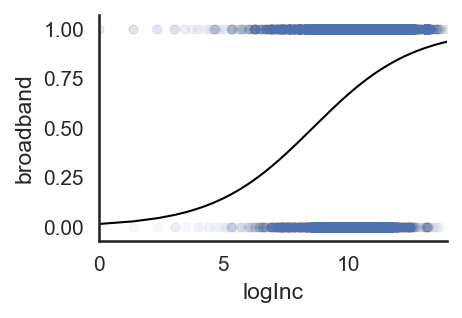

In [24]:
fig, ax = plt.subplots(figsize = (3, 2))

ipums_clean.plot(kind = "scatter", x = "logInc", y = "broadband", alpha = 0.01, ax = ax)
ipums_clean.plot(kind = "line", x = "logInc", y = "pred", color = "k", lw = 1, label = "_none", ax = ax)

In [25]:
np.e ** ipums_clean[ipums_clean.pred > 0.5].logInc.iloc[0]

5395.999999999993

(5, 15)

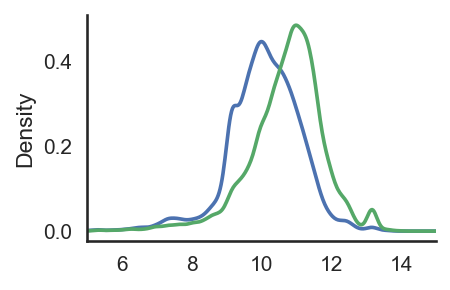

In [26]:
fig, ax = plt.subplots(figsize = (3, 2))
ipums_clean.groupby("broadband").logInc.plot.density(ax = ax)

ax.set_xlim(5, 15)

WOW!?  So half of households with just $5.4k of earnings have broadband!?

Now same plot but for kids -- 

Optimization terminated successfully.
         Current function value: 0.546492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477917
         Iterations 6


/home/jsaxon/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8f08736b00> has a label of '_none' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))
/home/jsaxon/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:593: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8f08732ac8> has a label of '_none' which cannot be automatically added to the legend.
  'legend.'.format(handle, label))


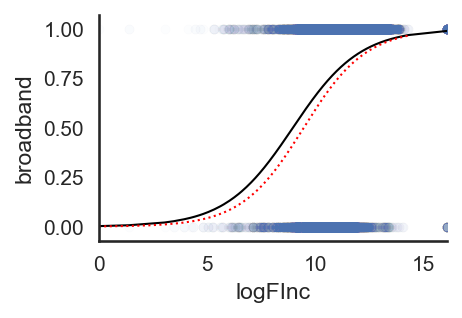

In [27]:
ipums_kids = ipums[["broadband", "sex", "AGE", "logFInc", "C", "isGQ"]].copy()
ipums_kids.query("AGE < 18 & ~isGQ", inplace = True)
ipums_kids.replace({-np.inf : np.nan}, inplace = True)
ipums_kids.sort_values("logFInc", inplace = True)


lfitAll = logit(ipums_clean.broadband, ipums_clean[["logFInc", "C"]], missing = "drop").fit()
ipums_clean["pred"] = lfitAll.predict(ipums_clean[["logFInc", "C"]])
ipums_clean.sort_values(by = "logFInc", inplace = True)

lfitK = logit(ipums_kids.broadband, ipums_kids[["logFInc", "C"]], missing = "drop").fit()
ipums_kids["pred"] = lfitK.predict(ipums_kids[["logFInc", "C"]])

fig, ax = plt.subplots(figsize = (3, 2))

ipums_kids.plot(kind = "scatter", x = "logFInc", y = "broadband", alpha = 0.01, ax = ax)
ipums_kids.plot(kind = "line", x = "logFInc", y = "pred", color = "k", lw = 1, label = "_none", ax = ax)

ipums_clean.plot(kind = "line", x = "logFInc", y = "pred", color = "r", ls = ":", lw = 1, label = "_none", ax = ax)

So households with kids are moderately more likely to have internet, at a given income level.

In [28]:
ipums.groupby("sex").broadband.mean()

sex
Female    0.715674
Male      0.727991
Name: broadband, dtype: float64

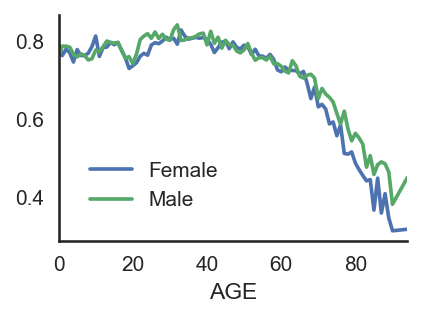

In [29]:
fig, ax = plt.subplots(figsize = (3, 2))

ipums[~ipums.isGQ].groupby(["AGE", "sex"]).broadband.mean().unstack().plot(ax = ax)

ax.get_legend().set_title("")